    Topic: Titanic EDA & Logistic Regression
    Author: Kartik M
    Start Date: January 4, 2022
    End Date: January 27, 2022
    

Exploring the Titanic dataset. Following are the steps that I have followed: -


*   Data Preprocessing
    * Data Retrival
    * Data Cleaning
*   Data Exploration
    * Summary Statistics
    * Data Visualization
*   Feature Engineering
    * One Hot Encoding
    * Log Transformation
    * Feature Addition
    * Feature Scaling
*   Model Training
    * Logistic Regression
*   Model Evaluation
    * Accuracy Score (Jaccard Similarity)
    * Confusion Matrix



-----------------------------------------------------
# Initial Imports
-----------------------------------------------------

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preprocessing

In [3]:
## -------------------------
## DATA RETRIEVAL & CLEANING
## -------------------------

# filepath of the dataset
file_path = 'train.csv'

# columns to be dropped from the data
to_drop = ['Name', 'Cabin', 'Ticket'] 

# reading the dataset and dropping unnecessary columns
data = pd.read_csv(file_path).drop(to_drop, axis=1)

# reordering & renaming the columns
data = data[['PassengerId', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Age', 'Fare', 'Embarked', 'Survived']]
data.rename(columns={'PassengerId':'pId', 'Pclass':'pClass', 'Sex':'sex', 'Age':'age', 'Survived':'survived', 'Embarked':'embarked', 'Fare':'fare', 'Parch':'parCh', 'SibSp':'sibSp'}, inplace=True)

# adding a temperory pClass_name column for better readability when I explore the data
# will drop the new column later
data['pClass_name'] = data["pClass"].replace({1:'upper', 2:'middle', 3:'lower'})

### DATA NOW SUCCESSFULLY RETRIEVED

# displaying data
data.head()

,pId,pClass,sex,sibSp,parCh,age,fare,embarked,survived,pClass_name
0,1,3,male,1,0,22.0,7.2500,S,0,lower
1,2,1,female,1,0,38.0,71.2833,C,1,upper
2,3,3,female,0,0,26.0,7.9250,S,1,lower
3,4,1,female,1,0,35.0,53.1000,S,1,upper
4,5,3,male,0,0,35.0,8.0500,S,0,lower


pId              0
pClass           0
sex              0
sibSp            0
parCh            0
age            177
fare             0
embarked         2
survived         0
pClass_name      0
dtype: int64


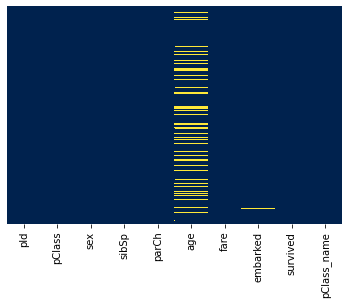

In [4]:
## --------------------------------------------------------
## Checking for null values in the dataset by visualization
## --------------------------------------------------------
 
nan_values = data.isnull().sum()
print(nan_values)

# that implies, of the 891 entries, 177 in the age column are NaN (null) and 2 in embarked are also null.
# visualizing the same using a heatmap

import seaborn as sns

sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='cividis')

As we can see in the above heat map, there are many NaN values in the age column. I will impute the NaN values. There are 2 methods to do so, both the methods give almost equally good results as proven in the link: -

*   Imputing with the mean of the ages (on the basis of pClass and sex)
*   Imputing  NaN values using a RandomForestRegressor (https://stackoverflow.com/a/63651173)



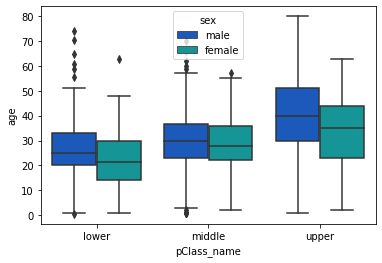

In [ ]:
# Visualizing boxplot to gather information from data

sns.boxplot(x='pClass_name', y='age', data=data, palette='winter', hue='sex', order=['lower', 'middle', 'upper'])

It is evident from the boxplot above that the median ages vary significantly (hence mean will also vary) on the basis of pClass and not very significantly on the basis of sex (but still). So it is not wise to impute the ages by taking the mean of all the datapoints. I will take mean on the basis of pClass and sex and then impute.

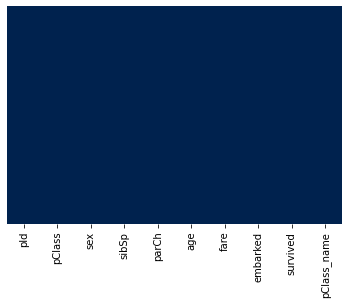

In [5]:
## -------------------------------------------
## Imputing the NaN ages with respective means
## -------------------------------------------

# here the groupby function will return series grouped by pClass and sex and then 
# the apply function will applye our lambda function on each datapoint

data['age'] = data['age'].groupby([data['pClass'], data['sex']]).apply(lambda x: x.fillna(x.mean()))

## And for the 2 NaN values in Embarked we will drop those 2 datapoints
data.dropna(inplace=True)
 
# plotting a heatmap to check for NaN values
sns.heatmap(data.isnull(), cbar=False, cmap='cividis', yticklabels=False)

# Data Exploration
  # -> Summary & Visual Statistics




---------------------------------------------------------------------------

% of people survived:  38.2 %

---------------------------------------------------------------------------



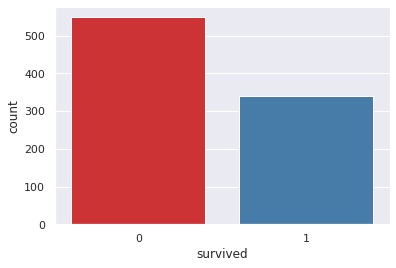

In [ ]:
### DATA EXPLORATION
## In this section, I will cover Summary and Visual Statistics

## Visualizing the number of people that survived the accident

# computing percentage of people that survived
percentage_survived = data.survived.mean()
percentage_survived *= 100

# printing the percentage
print("\n---------------------------------------------------------------------------\n")
print('% of people survived: ',round(percentage_survived, 1), '%')
print("\n---------------------------------------------------------------------------\n")

# representing the same data visually 
sns.set_theme(style='darkgrid')
sns.countplot(x='survived', data=data, palette='Set1')

# Gender bias in rates of survival
From the below stats it is evident that females are more likely to have survived the titanic incident than males. It was so because women and children were given priority to get onto the boats (This was the policy that was adopted by the crew). 
 

*   Percentage of females that survived: 74.2%
*   Percentage of males that survived: 18.9%

The difference is staggering.  


---------------------------------------------------------------------------

% of females survived:  74.0 %
% of males survived:  18.9 %

---------------------------------------------------------------------------



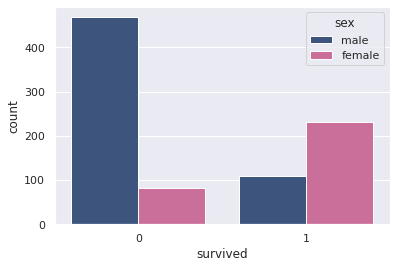

In [ ]:
## Analysing Gender Bias in Survival Rate

# computing the percentage of survival by sex
sex_percentage = data.groupby(['sex']).survived.mean()
sex_percentage *= 100

gender = ('females', 'males')

print("\n---------------------------------------------------------------------------\n")

# printing % of people surviving on the basis of sex
for i in range(sex_percentage.shape[0]):
   print("% of " + gender[i] + " survived: ", round(sex_percentage[i], 1),"%")

print("\n---------------------------------------------------------------------------\n")

# representing the same data visually 
sns.countplot(x='survived', hue='sex', data=data, palette=['#325288', '#D96098'])

# Social bias in rates of survival
As is evident from the graph below, the upper class passengers were much more likely to have survived than the middle and the lower class passengers.

*   Percentage of upper class that survived: 63.0%
*   Percentage of middle class that survived: 47.3%
*   Percentage of lower class that survived: 24.2%




---------------------------------------------------------------------------

% of lower survived:  24.2 %
% of middle survived:  47.3 %
% of upper survived:  62.6 %

---------------------------------------------------------------------------



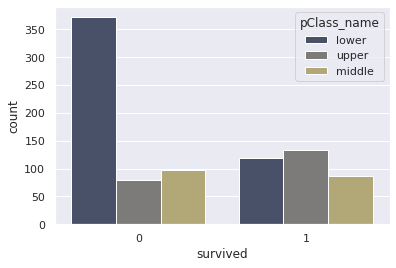

In [ ]:
## Analysing Social Bias in Survival Rate

# Computing percentage of survival by pClass
pClass_percentage = data.groupby(['pClass_name']).survived.mean()
pClass_percentage *= 100

clas = ('lower', 'middle', 'upper')

print("\n---------------------------------------------------------------------------\n")

# printing % of people surviving on the basis of class
for i in range(pClass_percentage.shape[0]):
   print("% of " + clas[i] + " survived: ", round(pClass_percentage[i], 1), '%')

print("\n---------------------------------------------------------------------------\n")
  
# representing the same data visually 
sns.countplot(x='survived', hue='pClass_name', data=data, palette='cividis')

# Sex-Ratio Analysis
It is evident from the graph below that the sex ratio is much lower in the lower class showing that there was limited luxury for women in the lower strata of the society.

*    Lower Class: 41.5 %
*    Middle Class: 70.4 %
*    Upper Class: 75.4 %


[41.5, 70.37, 75.41]


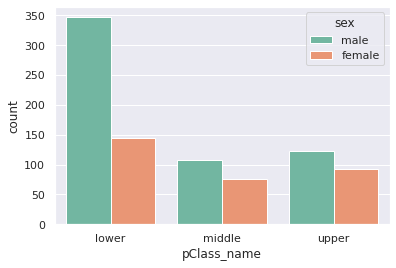

In [ ]:
## Sex-Ratio Analysis

sns.countplot(x='pClass_name', data=data, hue='sex', order=['lower', 'middle', 'upper'], palette='Set2')

sex_byClass = data.groupby(['sex', 'pClass_name']).pId.count()

sex_ratio = []

for i in range(3):
   sex_ratio.append(round((sex_byClass[i] / sex_byClass[i+3] * 100), 2))

print(sex_ratio)  # sex ratio is much better at the middle and the upper classes, 
                  # showing limited luxury for women in the lower strata 

----------------------------------------------------------
# Feature Engineering
Done with EDA, now I will prepare the data to be fitted to a Logistic Regressor

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pId          889 non-null    int64  
 1   pClass       889 non-null    int64  
 2   sex          889 non-null    object 
 3   sibSp        889 non-null    int64  
 4   parCh        889 non-null    int64  
 5   age          889 non-null    float64
 6   fare         889 non-null    float64
 7   embarked     889 non-null    object 
 8   survived     889 non-null    int64  
 9   pClass_name  889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 76.4+ KB


In [7]:
# dropping unnecessary columns 
train = data.drop(['pId', 'pClass_name'], axis=1)

In [98]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [248]:
## --------------------------------------------------------------------------
## Applying One Hot Encoding to the categorical variables ('sex', 'embarked')
## --------------------------------------------------------------------------

# Firstly, I'll LabelEncode the categorical variables
le = LabelEncoder()

embarked_le = train.embarked    # label encoded embarked feature
embarked_le = le.fit_transform(embarked_le)
embarked_le = pd.DataFrame(embarked_le)
embarked_le.rename(columns={0:'embarked_en'}, inplace=True)


# Now I'll OneHotEncode the LabelEncoded data
ohe = OneHotEncoder(sparse=False)

embarked_ohe = embarked_le.values   # one hot encoded embarked feature
embarked_ohe = ohe.fit_transform(embarked_ohe)
embarked_ohe = pd.DataFrame(embarked_ohe)
embarked_ohe.drop(columns=2, inplace=True)
embarked_ohe.rename(columns={0:'C', 1:'Q'}, inplace=True)


## now encoding sex feature
sex_le = train.sex    # label encoded sex feature
sex_le = le.fit_transform(sex_le)
sex_le = pd.DataFrame(sex_le)
sex_le.rename(columns={0:'male'}, inplace=True)

sex_ohe = sex_le    # one hot encoded sex feature


# Adding the encoded variables to our training set
encoded_ohe = pd.concat([embarked_ohe, sex_ohe], axis=1)
train_ohe = pd.concat([train.drop(['sex', 'embarked'], axis=1), encoded_ohe], axis=1)

# Don't know why but some NaN values creeped in. 2 whole rows became NaN
train_ohe.dropna(inplace=True)

## Next up, I'll apply Log transformation to the 'Fare' feature because it has some outliers

In [250]:
## -----------------------------------------------------------------
## Applying Log Transformation to 'Fare' feature to remove outliers
## -----------------------------------------------------------------

train_log = train_ohe.copy()
train_log['fare_log'] = np.log1p(train_log['fare'])
train_log.drop(['fare'], axis=1, inplace=True)

## Next up, I'll add a new 'family' feature (just to increase complexity) 
## where family = sibSp + parCh; indicating your total family members onboard

In [252]:
## -----------------------
## Adding 'family' feature
## -----------------------

train_final = train_log.copy()
train_final['family'] = train_final['sibSp'] + train_final['parCh']

X = train_final.drop(['survived'], axis=1)
Y = train_final['survived']

## Now data is ready to be SCALED and then FITTED

(887,)

------------------------------------------------------------------
# Model Training
------------------------------------------------------------------

In [253]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [262]:
## Training a logistic regression model with our OneHotEncoded training data 

# Performing a train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=69)

# Standard scaler to scale our features
sc = StandardScaler() 
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

# Fitting the model to our data
log_reg = LogisticRegression()
log_reg.fit(x_train_scaled, y_train)

# Making predictions
y_pred = log_reg.predict(x_test_scaled)

-----------------------------------------------------------
# Model Evaluation
-----------------------------------------------------------

In [263]:
## Model Evaluation

LogReg_score = accuracy_score(y_test, y_pred)

# Accuracy score of our model
print("Accuracy Score: ", LogReg_score)

Accuracy Score:  0.7378277153558053


Confusion Matrix: 
 [[156  23]
 [ 47  41]]



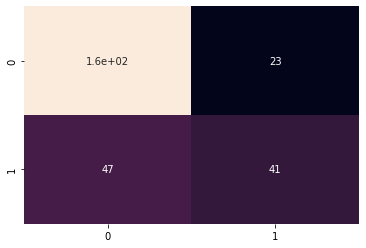

In [264]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n",c_matrix, end='\n\n')

# Visualizing the confusion matrix using a heatmap
sns.heatmap(c_matrix, annot=True, cbar=False)

In [266]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82       179
         1.0       0.64      0.47      0.54        88

    accuracy                           0.74       267
   macro avg       0.70      0.67      0.68       267
weighted avg       0.73      0.74      0.73       267

